In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Dropout, ReLU, concatenate
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import StandardScaler

/usr/lib64/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/usr/lib64/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/usr/lib64/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Exploratory Data Analysis

In [2]:
train_df = pd.read_csv('../train.csv', index_col='id') #set index on 'id' column
test_df = pd.read_csv('../test.csv', index_col='id')

In [3]:
train_df.head()

,amount_value,amount_currency,channel,deviceDetails_browser,deviceDetails_device,deviceDetails_deviceIp,merchantRefTransactionId,paymentMethod_apmType,paymentMethod_cardNumber,paymentMethod_cardType,paymentMethod_cardSubType,paymentMethod_cvv,paymentMethod_encodedPaymentToken,paymentMethod_expiryMonth,paymentMethod_expiryYear,transaction_time,class
id,,,,,,,,,,,,,,,,,
0,18253.30,USD,virtual,edge,pos,134.93.42.168,544011954,magstripe,2174-3628-6995-3987,JCB,Student,61,szQSTkeL,6,2027,2020-08-30 05:21:24,0
1,15870.89,USD,virtual,chrome,pos,78.92.229.26,9718272187,nfcc,4498-2553-8930-9552,JCB,Student,200,fdptXXrc,1,2026,2020-09-03 23:21:01,0
2,41109.80,USD,online,chromio,pos,197.84.118.231,1659938058,magstripe,8246-8688-8907-4387,JCB,Prepaid,259,UTXzvode,0,2021,2020-08-03 11:43:53,1
3,70604.95,USD,virtual,chrome,mobile,192.113.64.253,986924301,magstripe,3563-5044-6927-1494,JCB,Business,685,gVRZqrdu,7,2023,2020-07-22 04:28:32,0
4,51216.66,USD,virtual,chrome,mobile,48.81.200.252,9399699174,nfcc,4253-0351-2318-7737,JCB,Business,131,FGZLLHSX,6,2025,2020-02-29 13:35:21,0


In [4]:
test_df.head()

,amount_value,amount_currency,channel,deviceDetails_browser,deviceDetails_device,deviceDetails_deviceIp,merchantRefTransactionId,paymentMethod_apmType,paymentMethod_cardNumber,paymentMethod_cardType,paymentMethod_cardSubType,paymentMethod_cvv,paymentMethod_encodedPaymentToken,paymentMethod_expiryMonth,paymentMethod_expiryYear,transaction_time,class
id,,,,,,,,,,,,,,,,,
0,85621.45,USD,virtual,chrome,pos,225.76.238.186,2534859727,magstripe,6444-9854-4855-9248,Discover,Student,394,uCuKsvrW,0,2024,2020-09-05 23:30:39,1
1,6885.37,USD,online,edge,pos,22.235.47.168,3373234617,magstripe,7374-1462-5965-4580,JCB,Business,480,lVYWecct,9,2021,2020-08-04 07:08:00,0
2,60146.36,USD,virtual,edge,pos,34.50.211.154,4596280497,chip,2366-2404-8271-1630,Discover,Student,263,iXTHSnGH,11,2022,2020-08-02 18:52:19,0
3,40372.97,USD,virtual,edge,mobile,35.47.40.5,7486781647,magstripe,1528-9270-7336-2735,Visa,Business,469,nFnmjYWb,1,2027,2020-06-24 18:42:29,1
4,43803.75,USD,virtual,chrome,pos,247.164.216.72,8375107852,nfcc,8977-0947-5649-8057,Visa,Student,162,gMcMMAuC,4,2026,2020-03-19 18:53:16,1


In [5]:
train_df.shape

(100000, 17)

In [6]:
test_df.shape

(10000, 17)

- convert transaction_time into timestamp format

In [7]:
initial_time = list(train_df['transaction_time'])

In [8]:
time_in_seconds = []
for time_val in initial_time:
    date_time_obj = datetime.datetime.strptime(time_val, '%Y-%m-%d %H:%M:%S')
    time_in_seconds.append(date_time_obj.timestamp())

In [9]:
train_df = train_df.assign(time_in_seconds = time_in_seconds)

- compute the difference between the older transaction and the others, time based

In [10]:
dif_time = []
the_older_trans_date = min(time_in_seconds)
for time_val in time_in_seconds:
    delta = time_val - the_older_trans_date
    dif_time.append(delta)

In [11]:
train_df = train_df.assign(time_dif = dif_time)

In [12]:
train_df.sort_values(by=['time_dif'], inplace=True)

- normalize time_dif column and save to norm_time_dif, same for amount_value - stored in norm_amount

In [13]:
train_df['norm_time_dif'] = StandardScaler().fit_transform(train_df[['time_dif']])

In [14]:
train_df['norm_amount'] = StandardScaler().fit_transform(train_df[['amount_value']])

In [15]:
numerical_columns = ['merchantRefTransactionId', 'paymentMethod_cvv', 'paymentMethod_expiryMonth', 'paymentMethod_expiryYear',
                     'amount_value', 'time_in_seconds', 'time_dif', 'norm_time_dif', 'norm_amount', 'transaction_time']

In [16]:
categorical = []
for column in train_df.columns:
    if column not in numerical_columns:
        categorical.append(column)

In [17]:
categorical

['amount_currency',
 'channel',
 'deviceDetails_browser',
 'deviceDetails_device',
 'deviceDetails_deviceIp',
 'paymentMethod_apmType',
 'paymentMethod_cardNumber',
 'paymentMethod_cardType',
 'paymentMethod_cardSubType',
 'paymentMethod_encodedPaymentToken',
 'class']

In [18]:
categorical.remove('class')

In [19]:
categorical.remove('amount_currency')

In [20]:
categorical.remove('deviceDetails_deviceIp')
categorical.remove('paymentMethod_cardNumber')

In [21]:
categorical.remove('paymentMethod_encodedPaymentToken')

In [22]:
categorical

['channel',
 'deviceDetails_browser',
 'deviceDetails_device',
 'paymentMethod_apmType',
 'paymentMethod_cardType',
 'paymentMethod_cardSubType']

In [23]:
train_df[categorical] = train_df[categorical].astype('category')

In [24]:
encoded_categorical_feats = pd.DataFrame()
for col in categorical:
    train_df[col] = train_df[col].cat.codes

In [25]:
classes = train_df['class'].values

In [26]:
to_drop = ['amount_currency', 'deviceDetails_deviceIp', 'merchantRefTransactionId', 
           'paymentMethod_cardNumber', 'paymentMethod_encodedPaymentToken',
          'transaction_time', 'class', 'norm_time_dif', 'norm_amount']

In [27]:
train_df.drop(columns=to_drop, inplace=True)

In [28]:
x_train, x_val, y_train, y_val = train_test_split(train_df, 
                                                  classes,
                                                  test_size=0.25,
                                                  stratify=classes,
                                                  shuffle=True)

In [29]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)

In [30]:
len(x_train)

75000

In [31]:
x_train.shape

(75000, 12)

In [32]:
inp = Input(shape=(x_train.shape[1],), name='inp')
l1 = Dense(32, activation='relu', name='l1', use_bias=False)(inp)
otp = Dense(1, activation='sigmoid', name='otp')(l1)

In [33]:
model = Model(inputs=inp, outputs=otp)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0, mode='auto', patience=1))
callbacks.append(ModelCheckpoint('models/nn_model_4.h5',
                                 monitor='val_acc',
                                 save_weights_only=False, 
                                 save_best_only=True,
                                 mode='auto'))

In [35]:
model.fit(x_train, y_train, epochs=20, verbose=1,
          validation_data=(x_val, y_val), batch_size=64,
          shuffle=True, callbacks=callbacks, initial_epoch=0)

Epoch 1/20
1172/1172 [==============================] - 2s 1ms/step - loss: 0.7012 - accuracy: 0.4988 - val_loss: 0.6938 - val_accuracy: 0.5008
Epoch 2/20
1172/1172 [==============================] - 1s 1ms/step - loss: 0.6942 - accuracy: 0.5023 - val_loss: 0.6942 - val_accuracy: 0.4976


In [36]:
model.evaluate(x_train, y_train)

2344/2344 [==============================] - 2s 834us/step - loss: 0.6932 - accuracy: 0.5082


[0.6931957006454468, 0.5082266926765442]

In [37]:
model.evaluate(x_val, y_val)

782/782 [==============================] - 1s 764us/step - loss: 0.6942 - accuracy: 0.4976


[0.694208025932312, 0.4976400136947632]

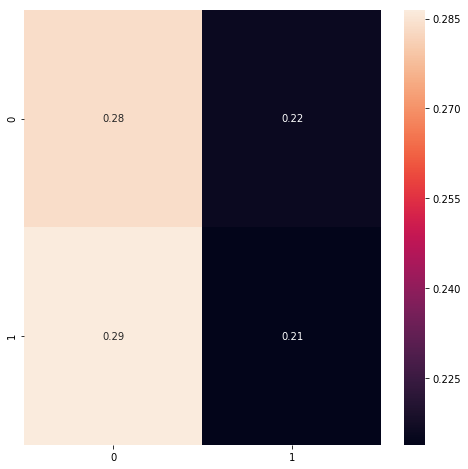

In [38]:
pred_model = model.predict(x_val)
cm = confusion_matrix(y_val, pred_model.round())
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2f')

## RandomForest for features importance 

In [39]:
rf = RandomForestClassifier(n_estimators=300)

In [40]:
%time rf.fit(x_train, y_train)

CPU times: user 52.7 s, sys: 288 ms, total: 52.9 s
Wall time: 53.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

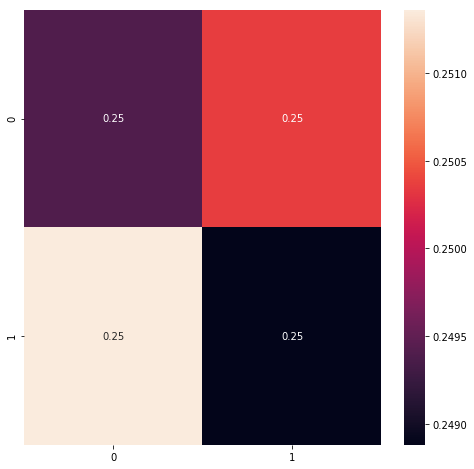

In [41]:
pred_rf = rf.predict(x_val)
y_rf = y_val
cm = confusion_matrix(y_rf, pred_rf)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2f')

In [42]:
fi = pd.DataFrame({
'feat_name': list(train_df.columns),
'imp': rf.feature_importances_}
).sort_values('imp', ascending=False)
display(fi)

,feat_name,imp
0,amount_value,0.171530
7,paymentMethod_cvv,0.165859
10,time_in_seconds,0.153928
11,time_dif,0.153857
8,paymentMethod_expiryMonth,0.081268
9,paymentMethod_expiryYear,0.076518
5,paymentMethod_cardType,0.041040
6,paymentMethod_cardSubType,0.036178
2,deviceDetails_browser,0.033120
4,paymentMethod_apmType,0.031565
